In [1]:
from gcn_scripts import GCN_Model, graph, coarsening
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\s

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [3]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [4]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [5]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [6]:
train_set = train_set.reshape((-1,64,64))
train_set = np.transpose(train_set, (0, 2, 1))
test_set = test_set.reshape((-1,64,64))
test_set = np.transpose(test_set, (0, 2, 1))
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392,) (3598, 64, 64) (3598,)


In [7]:
#set data for gcn model
train_label_holder = np.ones((0))
test_label_holder = np.ones((0))

for i in range(train_set.shape[0]):
    temp = np.full((64), train_label[i])
    train_label_holder = np.concatenate((train_label_holder, temp), axis=0)
    
for i in range(test_set.shape[0]):
    temp = np.full((64), test_label[i])
    test_label_holder = np.concatenate((test_label_holder, temp), axis=0)

train_set = train_set.reshape((-1,64))
test_set = test_set.reshape((-1,64))
train_label = train_label_holder
test_label = test_label_holder
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(921088, 64) (921088,) (230272, 64) (230272,)


In [8]:
dist, idx = graph.distance_scipy_spatial(train_set.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

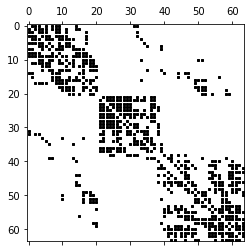

In [9]:
plt.spy(A, markersize=2, color='black');

In [10]:
graphs, perm = coarsening.coarsen(A, levels=5, self_connections=False)

Layer 0: M_0 = |V| = 96 nodes (32 added),|E| = 401 edges
Layer 1: M_1 = |V| = 48 nodes (14 added),|E| = 169 edges
Layer 2: M_2 = |V| = 24 nodes (7 added),|E| = 62 edges
Layer 3: M_3 = |V| = 12 nodes (3 added),|E| = 23 edges
Layer 4: M_4 = |V| = 6 nodes (1 added),|E| = 8 edges
Layer 5: M_5 = |V| = 3 nodes (0 added),|E| = 3 edges


In [11]:
X_train = coarsening.perm_data(train_set, perm)
X_test  = coarsening.perm_data(test_set,  perm)

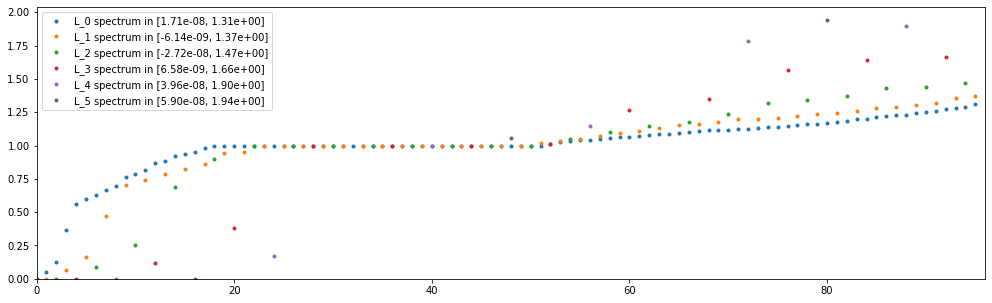

In [12]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [13]:
params = dict()
params['dir_name']       = 'Graph_Convolutional_Neural_Network'
params['num_epochs']     = 100
params['batch_size']     = 1024
params['eval_frequency'] = 100

# Building blocks.
params['filter'] = 'chebyshev5'
params['brelu']  = 'b2relu'
params['pool']   = 'mpool1'

# Architecture.
params['F'] = [16, 32, 64, 128, 256, 512]  # Number of graph convolutional filters.
params['K'] = [2, 2, 2, 2, 2, 2]           # Polynomial orders.
params['p'] = [2, 2, 2, 2, 2, 2]           # Pooling sizes.
params['M'] = [4]                          # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 0.001     # L2 regularization
params['dropout']        = 0.50      # Dropout rate
params['learning_rate']  = 0.000001  # Learning rate
params['decay_rate']     = 1         # Learning rate Decay == 1 means no Decay
params['momentum']       = 0         # momentum == 0 means Use Adam Optimizer
params['decay_steps']    = np.shape(train_set)[0] / params['batch_size']


In [ ]:
model = GCN_Model.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, train_label, X_test, test_label)

NN architecture
input: M_0 = 96
layer 1: cgconv1
representation: M_0 * F_1 / p_1 = 96 * 16 / 2 = 768
weights: F_0 * F_1 * K_1 = 1 * 16 * 2 = 32
biases: M_1 * F_1 = 96 * 16 = 1536
layer 2: cgconv2
representation: M_1 * F_2 / p_2 = 48 * 32 / 2 = 768
weights: F_1 * F_2 * K_2 = 16 * 32 * 2 = 1024
biases: M_2 * F_2 = 48 * 32 = 1536
layer 3: cgconv3
representation: M_2 * F_3 / p_3 = 24 * 64 / 2 = 768
weights: F_2 * F_3 * K_3 = 32 * 64 * 2 = 4096
biases: M_3 * F_3 = 24 * 64 = 1536
layer 4: cgconv4
representation: M_3 * F_4 / p_4 = 12 * 128 / 2 = 768
weights: F_3 * F_4 * K_4 = 64 * 128 * 2 = 16384
biases: M_4 * F_4 = 12 * 128 = 1536
layer 5: cgconv5
representation: M_4 * F_5 / p_5 = 6 * 256 / 2 = 768
weights: F_4 * F_5 * K_5 = 128 * 256 * 2 = 65536
biases: M_5 * F_5 = 6 * 256 = 1536
layer 6: cgconv6
representation: M_5 * F_6 / p_6 = 3 * 512 / 2 = 768
weights: F_5 * F_6 * K_6 = 256 * 512 * 2 = 262144
biases: M_6 * F_6 = 3 * 512 = 1536
layer 7: logits (softmax)
representation: M_7 = 4
weights: M

validation accuracy: 25.987528 (59842 / 230272), f1: 20.584596, loss: 0.000036
time: 319s (wall 295s)
step 2700 / 89950 (epoch 3.00 / 100):
learning_rate = 0.000100, loss_average = 0.000026
validation accuracy: 25.940192 (59733 / 230272), f1: 20.416464, loss: 0.000026
time: 341s (wall 316s)
step 2800 / 89950 (epoch 3.11 / 100):
learning_rate = 0.000100, loss_average = 0.000018
validation accuracy: 25.912399 (59669 / 230272), f1: 20.287735, loss: 0.000018
time: 365s (wall 339s)
step 2900 / 89950 (epoch 3.22 / 100):
learning_rate = 0.000100, loss_average = 0.000013
validation accuracy: 25.887646 (59612 / 230272), f1: 20.182473, loss: 0.000012
time: 388s (wall 362s)
step 3000 / 89950 (epoch 3.34 / 100):
learning_rate = 0.000100, loss_average = 0.000009
validation accuracy: 25.852904 (59532 / 230272), f1: 20.101709, loss: 0.000008
time: 412s (wall 386s)
step 3100 / 89950 (epoch 3.45 / 100):
learning_rate = 0.000100, loss_average = 0.000006
validation accuracy: 25.828151 (59475 / 230272), f

validation accuracy: 24.709908 (56900 / 230272), f1: 16.775417, loss: 0.000000
time: 1807s (wall 1744s)
step 7000 / 89950 (epoch 7.78 / 100):
learning_rate = 0.000100, loss_average = 0.000000
validation accuracy: 24.832372 (57182 / 230272), f1: 16.780666, loss: 0.000000
time: 1856s (wall 1792s)
step 7100 / 89950 (epoch 7.89 / 100):
learning_rate = 0.000100, loss_average = 0.000000
validation accuracy: 24.920529 (57385 / 230272), f1: 16.723323, loss: 0.000000
time: 1905s (wall 1840s)
step 7200 / 89950 (epoch 8.00 / 100):
learning_rate = 0.000100, loss_average = 0.000000
validation accuracy: 24.976115 (57513 / 230272), f1: 16.599815, loss: 0.000000
time: 1955s (wall 1889s)
step 7300 / 89950 (epoch 8.12 / 100):
learning_rate = 0.000100, loss_average = 0.000000
validation accuracy: 25.004777 (57579 / 230272), f1: 16.429111, loss: 0.000000
time: 2006s (wall 1938s)
step 7400 / 89950 (epoch 8.23 / 100):
learning_rate = 0.000100, loss_average = 0.000000
validation accuracy: 25.038650 (57657 / 